# Class 7 - Regularization

## Regularized loss minimization

*Regularized loss minimization (RLM)* is a learning rule in which we minimize the empirical risk together with a regularization function $\rho : \mathbb{R}^d \to \mathbb{R}$, which often leads to slightly higher bias but significantly reduced variance in the bias-variance tradeoff.

If the hypothesis class is parametrized by $ \mathbf{w} \in \mathbb{R}^d$, then the regularized loss minimization rule outputs a hypothesis in 

$$\arg \min_{\mathbf{w} \in \mathbb{R}^d} \big(\hat{R}(\mathbf{w}) + \rho(\mathbf{w})\big).$$

The regularization function $\rho$ is typically chosen to penalize how complex the hypothesis is, in order to prevent overfitting. We will consider the most widely used types, the L1 and L2 regularization.

## L2 regularization

Taking $\rho(\mathbf{w}) = \lambda \| \mathbf{w} \|_2^2$, where $\lambda > 0$ is a scalar and the norm is $ \| \mathbf{w} \|_2 = \big(\sum_{j=1}^{d} (w^{(j)})^2\big)^{1/2}$, we have the learning rule 

$$\arg \min_{\mathbf{w} \in \mathbb{R}^d} \big(\hat{R}(\mathbf{w}) + \lambda \| \mathbf{w} \|_2^2 \big),$$

called *L2* (or *Tikhonov*) *regularization*. An equivalent way to write this problem is 

$$\arg \min_{\mathbf{w} \in \mathbb{R}^d} \hat{R}(\mathbf{w}) \quad \text{subject to} \ \sum_{j=1}^{d} \big(w^{(j)}\big)^2 \leq C,$$

which makes explicit the size constraint on the parameters.

### Ridge regression

Applying the RLM with L2 regularization to linear regression with the squared loss, called *ridge regression*, we obtain the learning rule

$$ \arg \min_{β \in \mathbb{R}^d} \bigg( \lambda \| β \|_2^2  + \frac{1}{n} \sum_{i=1}^{n} \big(y_i - \langle β , x_i \rangle \big)^2 \bigg).$$ 

To solve the minimization problem, we set the gradient equal to zero and obtain 

$$ (\lambda n I + X^T X) β = X^T y.$$

The matrix $\lambda n I + X^T X$ is invertible since it is positive definite for $\lambda > 0$, and we have the solution

$$ β =(\lambda n I + X^T X)^{-1}X^T y.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection, linear_model, metrics 

def L2_regularized_risk(X, y, l, beta):
    return l * (np.linalg.norm(beta)**2) + (1 / X.shape[0]) * (np.linalg.norm((X.dot(beta) - y) ** 2))

def ridge_regression_inv(X, y, l=1.0):
    n, d = X.shape
    a = (l * n) * np.identity(d) + np.transpose(X).dot(X)
    b = np.transpose(X).dot(y)
    beta = np.linalg.inv(a).dot(b)
    return beta

As the L2 norm is differentiable, learning problems using L2 regularization can also be solved by using gradient descent.

In [2]:
def ridge_regression_grad(X, y, l=1, alpha=0.1):
    n, d = X.shape
    result = np.zeros((d, 1))
    cost_new = L2_regularized_risk(X, y, l, result)
    cost_old = 0
    i = 0
    while (cost_new - cost_old) ** 2 > 10 ** (-10):
        gradient = (np.transpose(X)).dot(X.dot(result) - y) + (l * n) * np.identity(d).dot(result) ## Gradient updated for the regularization.
        alpha = (np.transpose(gradient).dot(gradient)) / (
            (np.transpose(gradient).dot(np.transpose(X))).dot(X.dot(gradient)))
        result -= (2 * alpha / n) * gradient
        cost_new, cost_old = L2_regularized_risk(X, y, l, result), cost_new
        i += 1
    return result

### Standardization

The ridge solutions are not equivariant under scaling of the inputs, so one standardizes the inputs before solving the minimization problem. This means that we take

\begin{align}
x_{new} = \frac{x_{old}−x_{mean}}{x_{sd}}, \quad y_{new} = \frac{y_{old}−y_{mean}}{y_{sd}},
\end{align}

and arrange our learning algorithm accordingly.

In [3]:
def ridge_regression_inv_std(X, y, l=1.0):
    ## Standardize data
    def standardize(X, mean_dataset, std_dataset):
        return (X-mean_dataset)/std_dataset
    
    x_mean = np.mean(X, axis=0)
    x_std = np.std(X, axis=0)
    y_mean = np.mean(y, axis=0)
    y_std = np.std(y, axis=0)
    
    X_new = standardize(X, x_mean, x_std)
    y_new = standardize(y, y_mean, y_std)
    
    ## The algorithm without standardization
    n, d = X_new.shape
    a = (l * n) * np.identity(d) + np.transpose(X_new).dot(X_new)
    b = np.transpose(X_new).dot(y_new)
    
    ## Renormalize beta
    beta_j = y_std * (np.linalg.inv(a).dot(b) / x_std.reshape(-1,1))
    beta_zero = y_mean - np.sum(beta_j*x_mean.reshape(-1,1))
    
    return np.vstack((beta_zero, beta_j))

In Scikit-learn, the **sklearn.linear_model** module has a built-in class for ridge regression with different computational solver possibilities.

In [4]:
from sklearn.linear_model import Ridge

clf = Ridge(alpha=1.0, fit_intercept=True, normalize=True, solver='auto') 
            ## alpha corresponds to the regularization strength.

### Regularization hyperparameter

Note that the regularization coefficient $\lambda$ is a hyperparameter for the ridge regression. If $\lambda = 0$, we have the standard non-regularized linear regression model. On the other hand, setting $\lambda$ to a high value, the L2 norm of $\beta$ will be heavily constrained, leading to a simpler model that may underfit.

To see the effect of putting a penalty on the L2 norm, let us try to fit a high degree polynomial given a simple dataset. Note that the oscillations in the predictors are getting smaller and the models are becoming simpler for higher regularization coefficients.

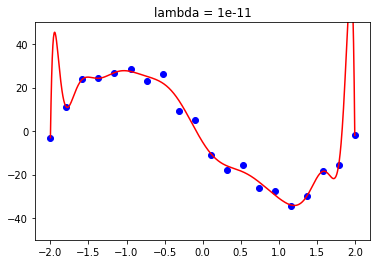

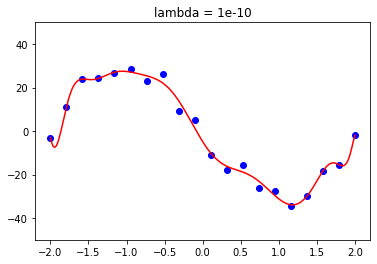

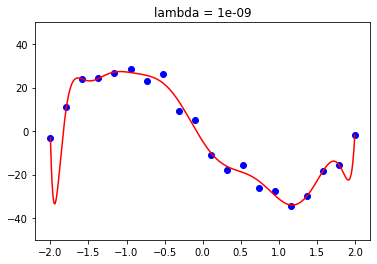

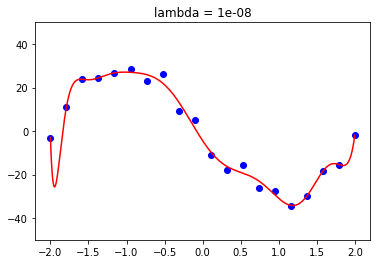

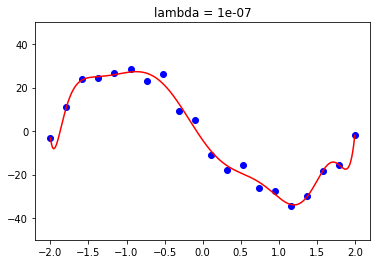

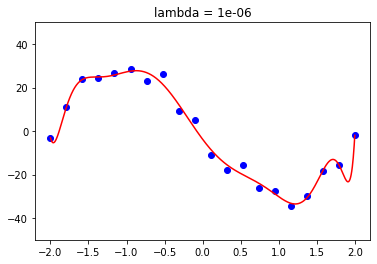

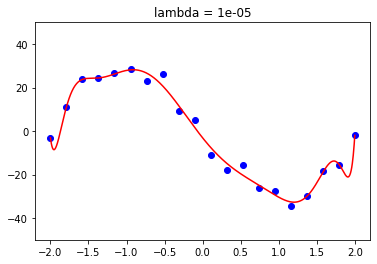

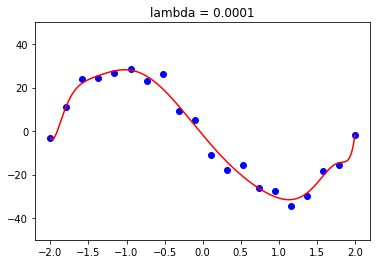

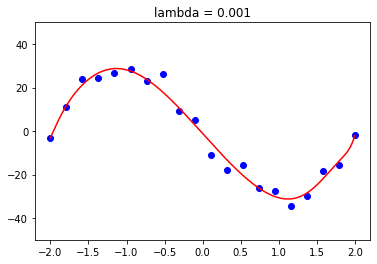

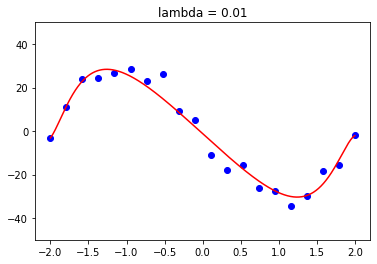

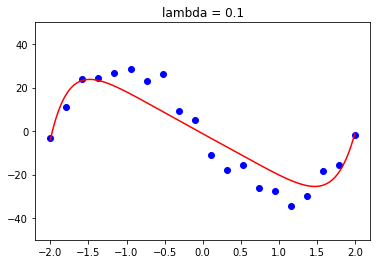

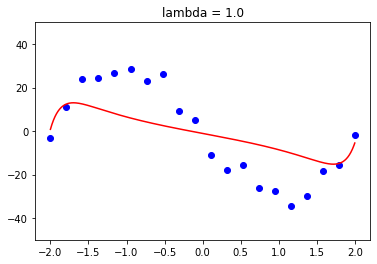

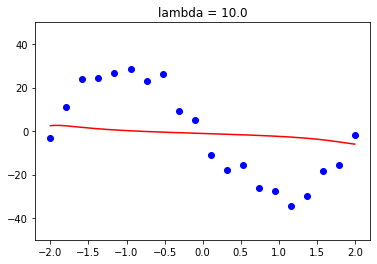

In [5]:
#np.random.seed(seed=781)
float_formatter = lambda x: "%.8f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

xp = np.linspace(-2, 2, 20)
yp = 10* xp ** 3 - 40 * xp + np.random.normal(0, 4, 20)
xp, yp = xp.reshape(-1,1), yp.reshape(-1,1)

from sklearn.preprocessing import PolynomialFeatures
def extend_sci(x, p): 
    poly = PolynomialFeatures(degree = p)
    return poly.fit_transform(x)

p=20 ## Degree of the polynomial.
a = np.linspace(min(xp),max(xp),num=1000).reshape(-1,1)
log_coef = np.linspace(-11, 1, 13) ## You may change the interval for zooming in!
coef = 10.0**log_coef 
for l in coef:
    plt.plot(xp, yp, 'ob')
    betap = ridge_regression_inv_std(extend_sci(xp, p)[:,1:], yp, l)
    b = extend_sci(a, p).dot(betap)
    plt.title('lambda = {}'.format(l))
    plt.ylim(-50,50)
    plt.plot(a, b, 'r')
    plt.show()

As another example, let us consider the Boston house-prices dataset.

In [6]:
boston = datasets.load_boston()
x_raw, y_raw = boston.data, boston.target
y_raw = y_raw.reshape(-1,1)

We wil try to fit a third degree polynomial to the normalized dataset by using ridge regression. Note that the number of features in the extended array becomes greater than the number of available samples, which may lead to overfitting in the standard linear regression. We also need to remove the first column (containing 1s) after transforming our matrix since we need to exclude the intercept in our ridge algorithm.

In [7]:
x_poly = extend_sci(x_raw, 3) 
x_poly = np.delete(x_poly, 0, 1) ## Removes the first column consisting of 1s.
print(x_poly.shape)

(506, 559)


Let us prepare our data by shuffling and splitting into train, validation, and test sets.

In [8]:
def shuffle(x, y):
    z = np.hstack((x, y))
    np.random.shuffle(z)
    return np.hsplit(z, [x.shape[1]])

x_poly, y = shuffle(x_poly, y_raw)

def validation_split(x, y, validation_size=0.15, test_size=0.15):
    n = x.shape[0]
    train_cut = int(np.floor(n * (1 - validation_size - test_size)))
    val_cut = train_cut + int(np.floor(n * validation_size))
    return x[:train_cut, ], x[train_cut:val_cut, ], x[val_cut:, ], y[:train_cut, ], y[train_cut:val_cut, ], y[val_cut:,]

x_train, x_validation, x_test, y_train, y_validation, y_test = validation_split(x_poly, y)

We may now use the validation set to compare the outcome for different values of $\lambda$ for hyperparameter selection.

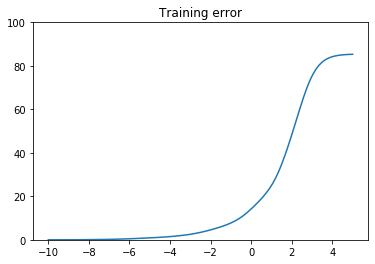

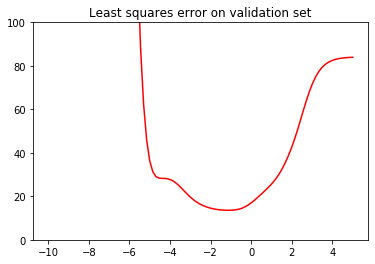

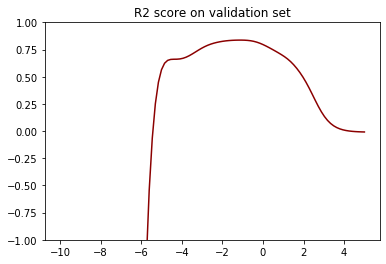

In [9]:
## Regularization coefficients in log-scale.
log_coef = np.linspace(-10, 5, 100) ## You may change the interval for zooming in!
coef = 10.0**log_coef 

reg_risk = []
reg_val_error = []
reg_R2 = []

def addones(x): ## Function for adding back the 1s we removed.
    x_add = np.hstack((np.ones((x.shape[0],1)), x))
    return x_add

for l in coef:
    beta = ridge_regression_inv_std(x_train, y_train, l) ## Parameters of our ridge regression algorithm.
        
    train_error = metrics.mean_squared_error(y_train, addones(x_train).dot(beta))
    reg_risk.append(train_error)
    
    val_error  = metrics.mean_squared_error(y_validation, addones(x_validation).dot(beta))
    reg_val_error.append(val_error)
    
    R2 = 1 - val_error / np.var(y_validation)
    reg_R2.append(R2)

    

plt.title('Training error')
plt.ylim(0,100)
plt.plot(log_coef, reg_risk)
plt.show()

plt.title('Least squares error on validation set')
plt.ylim(0,100)
plt.plot(log_coef, reg_val_error, 'r')
plt.show()

plt.title('R2 score on validation set')
plt.ylim(-1,1)
plt.plot(log_coef, reg_R2, color='darkred')
plt.show()


Selecting the hyperparameter that minimizes the least squares error on the validation set, we can test how our model performs. Note that the regularized version performs much better compared to the standard linear regression. 

In [10]:
l_hyp = 10**(-1.5) ## Chosen from validation.

## Standard linear regression for comparison.
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(x_train, y_train)
beta_lin_reg = np.vstack((lin_reg.intercept_,lin_reg.coef_.reshape(-1,1)))
test_error_lin_reg = metrics.mean_squared_error(y_test, lin_reg.predict(x_test))

## Ridge regression with the chosen hyperparameter.
beta_ridge = ridge_regression_inv_std(x_train, y_train, l_hyp)
test_error_ridge = metrics.mean_squared_error(y_test, addones(x_test).dot(beta_ridge))

print("Test error without regularization:", test_error_lin_reg)
print("Test error with regularization:", test_error_ridge)

Test error without regularization: 167183.77116230538
Test error with regularization: 10.505874495422178


Let's also have a look at the parameters which were chosen:

In [11]:
print("Difference of chosen parameters:", beta_lin_reg - beta_ridge)

Difference of chosen parameters: [[-1469.85618799]
 [-0.02230348]
 [-0.02113498]
 [-0.02555499]
 [-1.53001391]
 [-2.29172743]
 [-1.70245497]
 [0.15633803]
 [0.29985494]
 [-0.11046655]
 [0.23595018]
 [0.06334441]
 [-0.71119460]
 [0.07919442]
 [0.02058891]
 [-0.01845910]
 [-0.15570036]
 [-0.69513714]
 [-0.01912000]
 [-0.22907112]
 [-3.17848201]
 [-0.01705649]
 [0.09302331]
 [-1.94351707]
 [-0.24328416]
 [0.63924350]
 [0.17326034]
 [-0.20282786]
 [-1.22138179]
 [0.00123030]
 [0.03006210]
 [0.32623805]
 [-0.92864256]
 [-1.00988787]
 [1.89582496]
 [-0.44083247]
 [-0.07166321]
 [0.67423399]
 [-4.03517701]
 [-0.41064368]
 [-0.04927943]
 [-0.05812928]
 [-0.08906278]
 [-2.47915899]
 [0.21490465]
 [0.25041359]
 [1.53861558]
 [0.03483458]
 [-0.70923178]
 [-3.36163752]
 [-1.53001461]
 [0.50469173]
 [0.12005069]
 [-0.02371130]
 [-0.24825583]
 [-0.01680647]
 [-0.04609679]
 [-0.05693375]
 [-0.04588312]
 [-0.02383330]
 [-0.89933081]
 [-0.48459841]
 [-0.38682130]
 [0.63990878]
 [-0.11313147]
 [-0.15516

In [12]:
print("Parameter chosen by ridge:", beta_ridge)

Parameter chosen by ridge: [[8.58982897]
 [0.01055698]
 [-0.01286648]
 [0.01156433]
 [1.52977760]
 [2.29455126]
 [1.68843718]
 [0.01357666]
 [-0.33957545]
 [0.08484544]
 [0.00148768]
 [-0.03707615]
 [0.00334093]
 [0.02132400]
 [0.00007387]
 [-0.00287140]
 [0.00062083]
 [0.69442809]
 [-0.00189745]
 [-0.00184986]
 [0.00015036]
 [-0.00476679]
 [-0.00041773]
 [0.00000112]
 [0.00037085]
 [0.00006550]
 [0.00002045]
 [-0.00002467]
 [-0.00331826]
 [-0.00318462]
 [-0.01713253]
 [0.00054083]
 [-0.00020676]
 [-0.00120773]
 [-0.00116057]
 [-0.00001292]
 [0.00003356]
 [-0.00002260]
 [-0.00240541]
 [0.00184863]
 [0.04649816]
 [0.02048788]
 [0.00037434]
 [0.00027815]
 [-0.02464749]
 [0.00252417]
 [0.00007714]
 [-0.00121158]
 [0.00007708]
 [-0.00245592]
 [1.52977760]
 [-0.50573115]
 [-0.12198777]
 [0.01515805]
 [0.24599282]
 [0.01567796]
 [0.00241780]
 [0.05508669]
 [0.00397102]
 [0.02359155]
 [0.89747607]
 [0.52863108]
 [-0.00139729]
 [-0.63688289]
 [0.04610007]
 [0.00039931]
 [-0.04792355]
 [0.00382

A standard way of hyperparameter selection in this setting also is to use cross-validation techniques.

## L1 regularization - Lasso

Adding L1 regularization to a linear regression problem with the squared loss yields the *lasso* algorithm, defined as

$$ \arg \min_{β \in \mathbb{R}^d} \bigg( \lambda \| β \|_1  + \frac{1}{n} \sum_{i=1}^{n} \big(y_i - \langle β , x_i \rangle \big)^2 \bigg),$$

where we have the L1 norm $\| β \|_1 =\sum_{j=1}^{d} \vert β^{(j)} \vert$.

In practice, L1 regularization produces a sparse model that has most of its parameters $β^{(j)}$ equal to zero, provided the hyperparameter $\lambda$ is large enough. This leads to a feature selection by deciding which features are essential for prediction and which are not. 

Since the L1 penalty is not differentiable, different techniques from convex analysis and optimization, such as coordinate descent or subgradient methods, are required for obtaining solutions.

The lasso class in scikit-learn uses coordinate descent to fit the model.

In [13]:
clf = linear_model.Lasso(alpha=0.0001, fit_intercept = True, normalize = True, max_iter=1000) 
                                                        ## More iterations may be needed for convergence
clf.fit(x_train, y_train)

beta_lasso = clf.coef_.reshape(-1,1)
print(beta_lasso)

[[-0.31099806]
 [-0.04270154]
 [-0.24565474]
 [13.88290014]
 [-0.00000000]
 [10.52786624]
 [0.17855412]
 [-0.17429605]
 [-0.22830352]
 [-0.02041369]
 [0.15124289]
 [0.05378366]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [0.01790317]
 [3.90535235]
 [0.07462593]
 [-0.00532363]
 [-0.00056722]
 [-0.10748926]
 [-0.00000000]
 [0.00001044]
 [0.00234609]
 [0.00085228]
 [-0.00502553]
 [0.00000000]
 [-0.00000000]
 [-0.12845568]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [-0.10797350]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.32505723]
 [0.00112329]
 [0.00030445]
 [0.00000000]
 [0.00006440]
 [-0.01963598]
 [-0.28958702]
 [-12.76362350]
 [-0.78427772]
 [-0.00018072]
 [-0.02575033]
 [-0.07154548]
 [-0.00000000]
 [-0.00000000]
 [-0.00309873]
 [-0.00000000]
 [5.82051280]
 [0.74454737]
 [-0.01497983]
 [-0.00000000]
 [-0.28424892]
 [-0.00000633]
 [-0.30082129]
 [0.00000000]
 [-0.00000000]
 [0.

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.91921095259084, tolerance: 3.0248790649717514
  positive)


Note that some of the parameters are set to zero in this case. Choosing a larger hyperparameter leads to fewer essential features and a simpler model.

In [14]:
clf = linear_model.Lasso(alpha=0.01, fit_intercept = True, normalize=True)
clf.fit(x_train, y_train)

beta_lasso = clf.coef_.reshape(-1,1)
print(beta_lasso)

[[-0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [-0.00000000]
 [0.00000000]
 [-0.00000000]
 [0.00000000]
 [

# Practice yourself!

1. Try to use k-fold (or leave-one-out) cross-validation for selecting the hyperparameter $\lambda$ in ridge regression for the Boston dataset.
2. Apply and compare the ridge regression and lasso on the diabetes dataset from scikit-learn. Try to observe the essential features from the lasso algorithm.
3. Try to implement the code for the coordinate descent in the lasso.
4. How would you apply L1 and L2 regularization together to linear regression with squared loss? What would be the advantages in this case? (Hint: search *elastic net regularization*.)